In [58]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.nn.utils.rnn import pad_sequence
from sklearn.model_selection import train_test_split


In [2]:
device = torch.device("cuda")  # torch.device('cpu')

In [22]:
train_data = pd.read_pickle(r'train.pkl')
test_data = pd.read_pickle(r'test_no_target.pkl')

In [23]:
train_data, val_data = train_test_split(train_data, test_size=.2, random_state=1)
len(train_data), len(val_data)

(2351, 588)

In [32]:
class ClassicalMusicDataset(Dataset):
    def __init__(self, data, has_labels=True):
        self.has_labels = has_labels
        if self.has_labels:
            self.sequences, self.labels = zip(*data)
            self.labels = torch.tensor(self.labels, dtype=torch.long)
        else:
            self.sequences = data
        self.sequences = [torch.tensor(seq, dtype=torch.float32) for seq in self.sequences]

    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        if self.has_labels:
            return self.sequences[idx], self.labels[idx], len(self.sequences[idx])
        else:
            return self.sequences[idx], len(self.sequences[idx])        

In [34]:
pad = -100
def collate_fn(batch):
    if len(batch[0]) == 3:
        sequences, labels, lengths = zip(*batch)
        padded = pad_sequence(sequences, batch_first=True, padding_value=pad)
        return padded, torch.tensor(labels), torch.tensor(lengths)
    else:
        sequences, lengths = zip(*batch)
        padded = pad_sequence(sequences, batch_first=True, padding_value=pad)
        return padded, torch.tensor(lengths)

In [35]:
BATCH_SIZE = 32
train_dataset = ClassicalMusicDataset(train_data)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)

val_dataset = ClassicalMusicDataset(val_data)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

test_dataset = ClassicalMusicDataset(test_data, has_labels=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

In [56]:
class LSTMRegressor(nn.Module):
    def __init__(
        self, input_size, hidden_size, num_layers, out_size, bidirectional=False
    ):
        super().__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        if bidirectional:
            self.bidirectional = 2
        else:
            self.bidirectional = 1
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            bidirectional=bidirectional,
        )
        self.fc = nn.Linear(hidden_size * self.bidirectional, out_size)

    def init_hidden(self, batch_size):
        hidden = torch.zeros(
            self.num_layers * self.bidirectional, batch_size, self.hidden_size
        )
        state = torch.zeros(
            self.num_layers * self.bidirectional, batch_size, self.hidden_size
        )
        return hidden, state

    def forward(self, x, lengths, hidden):
        x_packed = pack_padded_sequence(x, lengths, batch_first=True, enforce_sorted=False)
        packed_output, (hn, cn) = self.lstm(x_packed, hidden)
        if self.bidirectional:
            last_hidden = torch.cat((hn[-2], hn[-1]), dim=1)
        else:
            last_hidden = hn[-1]
        out = self.fc(last_hidden)
        return out, (hn, cn)


model = LSTMRegressor(1, 128, 2, 5, bidirectional=True).to(device)
model

LSTMRegressor(
  (lstm): LSTM(1, 128, num_layers=2, bidirectional=True)
  (fc): Linear(in_features=256, out_features=5, bias=True)
)

In [57]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fun = nn.CrossEntropyLoss()

n_epochs = 50

all_loses = []

for epoch in range(n_epochs):
    epoch_loss = 0
    batch_count = 0
    for x, targets, lenghts in train_loader:
        x = x.to(device).unsqueeze(2)
        targets = targets.to(device)

        hidden, state = model.init_hidden(x.size(0))
        hidden, state = hidden.to(device), state.to(device)

        preds, _ = model(x, lenghts, (hidden, state))

        optimizer.zero_grad()
        loss = loss_fun(preds, targets) 
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        batch_count += 1

    avg_loss = epoch_loss / batch_count
    all_loses.append(avg_loss)
    print(f"Epoch: {epoch+1}\t\tAvg Loss: {avg_loss:.4f}")

Epoch 1/50 — Avg Loss: 1.2312
Epoch 2/50 — Avg Loss: 1.0545
Epoch 3/50 — Avg Loss: 0.9621
Epoch 4/50 — Avg Loss: 0.9058
Epoch 5/50 — Avg Loss: 0.8579
Epoch 6/50 — Avg Loss: 0.7966
Epoch 7/50 — Avg Loss: 0.7456
Epoch 8/50 — Avg Loss: 0.7263
Epoch 9/50 — Avg Loss: 0.6881
Epoch 10/50 — Avg Loss: 0.6520
Epoch 11/50 — Avg Loss: 0.6203
Epoch 12/50 — Avg Loss: 0.5646
Epoch 13/50 — Avg Loss: 0.5518
Epoch 14/50 — Avg Loss: 0.5147
Epoch 15/50 — Avg Loss: 0.5369
Epoch 16/50 — Avg Loss: 0.4579
Epoch 17/50 — Avg Loss: 0.4239
Epoch 18/50 — Avg Loss: 0.3857
Epoch 19/50 — Avg Loss: 0.3534
Epoch 20/50 — Avg Loss: 0.3230
Epoch 21/50 — Avg Loss: 0.2936
Epoch 22/50 — Avg Loss: 0.2845
Epoch 23/50 — Avg Loss: 0.2211
Epoch 24/50 — Avg Loss: 0.1895
Epoch 25/50 — Avg Loss: 0.2022
Epoch 26/50 — Avg Loss: 0.1792
Epoch 27/50 — Avg Loss: 0.1449
Epoch 28/50 — Avg Loss: 0.1383
Epoch 29/50 — Avg Loss: 0.1175
Epoch 30/50 — Avg Loss: 0.1387
Epoch 31/50 — Avg Loss: 0.1018
Epoch 32/50 — Avg Loss: 0.0653
Epoch 33/50 — Avg

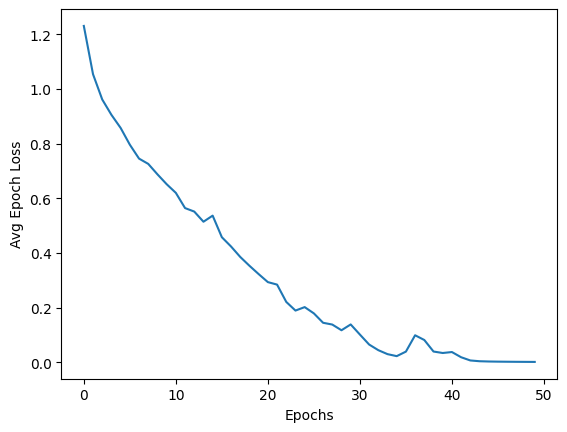

In [59]:
plt.plot(all_loses)
plt.xlabel('Epochs')
plt.ylabel('Avg Epoch Loss')
plt.show()

In [60]:
model.eval()
val_correct = 0
val_total = 0
all_preds = []
all_targets = []

with torch.no_grad():
    for x, targets, lengths in val_loader:
        x, targets = x.to(device).unsqueeze(2), targets.to(device)
        hidden, state = model.init_hidden(x.size(0))
        hidden, state = hidden.to(device), state.to(device)
        preds, _ = model(x, lengths, (hidden, state))
        predicted = torch.argmax(preds, dim=1)

        val_correct += (predicted == targets).sum().item()
        val_total += targets.size(0)

        all_preds.extend(predicted.cpu().tolist())
        all_targets.extend(targets.cpu().tolist())

val_accuracy = val_correct / val_total * 100
print(f"Validation Accuracy: {val_accuracy:.2f}%")

Validation Accuracy: 78.57%


In [ ]:
# torch.save(model.state_dict(), "model_rekurencyjny_1.pt")